In [12]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import markov_sim as markov
import json
import os
from datetime import datetime
from datetime import timedelta
from re import sub
from dateutil import  parser
from scipy.signal import periodogram
from sktime.transformations.series.outlier_detection import HampelFilter
from hampel import hampel

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'
data_list = []


In [72]:

for line in open('1.145414064.json', 'r'):
    data_list.append(json.loads(line))

runner_id = 2249834
runner_id_2 = 2251410
market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
market_timestamp = datetime.timestamp(market_datetime) * 1000


def get_list(runner_id):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)
    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df = df.resample('250ms').last()
    print(df)
    return df

def get_best_pricevol(runner_list, price, vol):

    back_list = []
    lay_list = []

    back_vol = []
    lay_vol = []

    for item in runner_list:
        if 'atb' in item[0]:
            if len(item[0]['atb']) > 1:
                temp = []
                for i in item[0]['atb']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    back_list.append([temp.max(), item[1]])
                    back_vol.append([item[0]['atb'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atb'][0][1] != 0:
                    back_list.append([item[0]['atb'][0][0], item[1]])
                    back_vol.append([item[0]['atb'][0][1], item[1]])

    for item in runner_list:
        if 'atl' in item[0]:
            if len(item[0]['atl']) > 1:
                temp = []
                for i in item[0]['atl']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    lay_list.append([temp.min(), item[1]])
                    lay_vol.append([item[0]['atl'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atl'][0][1] != 0:
                    lay_list.append([item[0]['atl'][0][0], item[1]])
                    lay_vol.append([item[0]['atl'][0][1], item[1]])

    del back_list[-1], lay_list[-1], back_vol[-1], lay_vol[-1]

    back_vol_arr = np.array(back_vol)
    lay_vol_arr = np.array(lay_vol)
    back_arr = np.array(back_list)
    lay_arr = np.array(lay_list)

    back_series = pd.Series(back_arr[:, 0], index=pd.to_datetime(back_arr[:, 1], unit='ms'))
    lay_series = pd.Series(lay_arr[:, 0], index=pd.to_datetime(lay_arr[:, 1], unit='ms'))
    back_vol_series = pd.Series(back_vol_arr[:, 0], index=pd.to_datetime(back_vol_arr[:, 1], unit='ms'))
    lay_vol_series = pd.Series(lay_vol_arr[:, 0], index=pd.to_datetime(lay_vol_arr[:, 1], unit='ms'))

    back_outliers = hampel(back_series, window_size=100)
    lay_outliers = hampel(lay_series, window_size=100)
    back_vol_outliers = hampel(back_vol_series, window_size=100)
    lay_vol_outliers = hampel(lay_vol_series, window_size=100)

    back_arr = np.delete(back_arr, back_outliers, axis=0)
    lay_arr = np.delete(lay_arr, lay_outliers, axis=0)
    back_vol_arr = np.delete(back_vol_arr, back_vol_outliers, axis=0)
    lay_vol_arr = np.delete(lay_vol_arr, lay_vol_outliers, axis=0)

    if price and not vol:
        return back_arr, lay_arr
    elif vol and not price:
        return back_vol_arr, lay_vol_arr

    return back_arr, lay_arr, back_vol_arr, lay_vol_arr

def best_available_df(runner_list, start, end):

    end_time = end + pd.Timedelta(60, 'sec')
    df_datetime = pd.date_range(start, end_time, freq='100ms')
    dt_shape = np.zeros(df_datetime.shape)

    back_arr, lay_arr, back_vol_arr, lay_vol_arr = get_best_pricevol(runner_list, True, True)

    df = pd.DataFrame({'back': dt_shape, 'lay': dt_shape, 'back vol': dt_shape, 'lay vol': dt_shape}, index=df_datetime)

    for index, time in enumerate(back_arr[:, 1]):
        df['back'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_arr[index, 0]
    for index, time in enumerate(lay_arr[:, 1]):
        df['lay'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_arr[index, 0]

    for index, time in enumerate(back_vol_arr[:, 1]):
        df['back vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_vol_arr[index, 0]
    for index, time in enumerate(lay_vol_arr[:, 1]):
        df['lay vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_vol_arr[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    print(df)
    df_back = df['back'].resample('250ms').last().rolling('1min').mean().shift(int(- 60 / .25))
    df_lay = df['lay'].resample('250ms').last().rolling('1min').mean().shift(int(- 60 / .25))
    df_back_vol = df['back vol'].resample('250ms').mean().rolling('1min').mean().shift(int(- 60 / .25))
    df_lay_vol = df['lay vol'].resample('250ms').mean().rolling('1min').mean().shift(int(- 60 / .25))
    df = pd.concat([df_back, df_lay, df_back_vol, df_lay_vol], axis=1)
    print(df)
    df = df.loc[start:end]
    df['back-lay avg'] = df[['back', 'lay']].mean(axis=1)
    df['spread'] = df['lay'] - df['back']
    df_pup = df['back vol'] / ( df['back vol'] + df['lay vol'] )
    pup_outliers = hampel(df_pup, window_size=100)
    print(pup_outliers)
    for index in pup_outliers:
        df_pup.iloc[index] = np.nan
    df_pup.interpolate(method='time', limit_direction='both', inplace=True)
    df_pup.name = 'pup'
    df = pd.concat([df, df_pup], axis=1)

    return df


def calc_score():
    pass


def get_markov_odds():
    pass



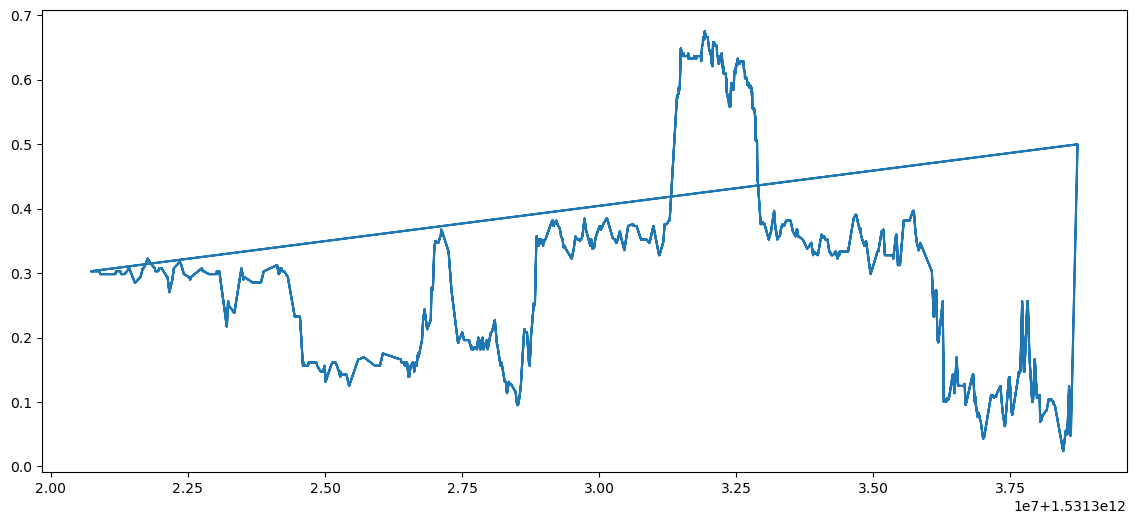

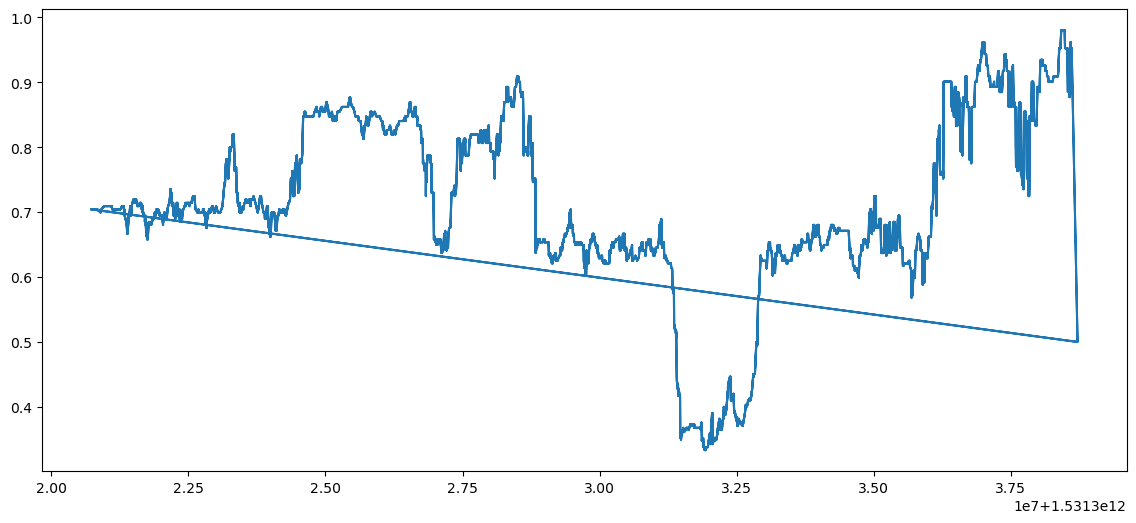

In [29]:
runner_list_1 = get_list(runner_id)
runner_list_2 = get_list(runner_id_2)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)
plt.figure(figsize=(14,6))
plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.figure(figsize=(14,6))
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])


In [30]:
df = odds_avg(runner_odds_1, runner_odds_2)

                         runner 1  1 - runner 2       avg
2018-07-11 14:52:07.000   0.30303      0.295775  0.299402
2018-07-11 14:52:07.250   0.30303      0.295775  0.299402
2018-07-11 14:52:07.500   0.30303      0.295775  0.299402
2018-07-11 14:52:07.750   0.30303      0.295775  0.299402
2018-07-11 14:52:08.000   0.30303      0.295775  0.299402
...                           ...           ...       ...
2018-07-11 19:50:14.500   0.05000      0.047619  0.048810
2018-07-11 19:50:14.750   0.05000      0.047619  0.048810
2018-07-11 19:50:15.000   0.05000      0.047619  0.048810
2018-07-11 19:50:15.250   0.05000      0.047619  0.048810
2018-07-11 19:50:15.500   0.05000      0.047619  0.048810

[71555 rows x 3 columns]


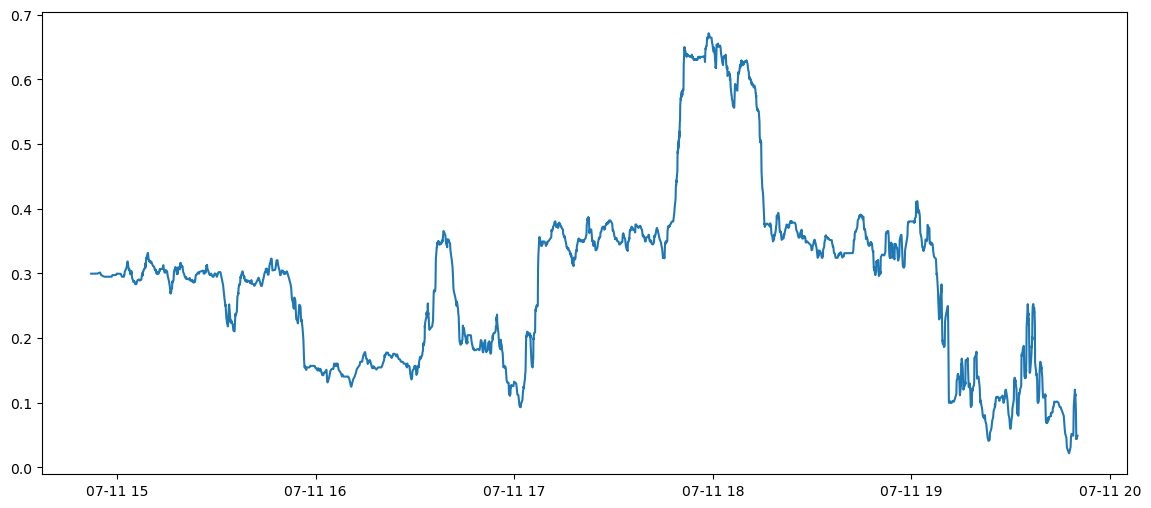

In [31]:
plt.figure(figsize=(14,6))
plt.plot(df['avg'])

In [73]:
start = df.first_valid_index()
end = df.last_valid_index()
df_runner_1 = best_available_df(runner_list_1, start, end)
print(df_runner_1)

                         back   lay  back vol  lay vol
2018-07-11 14:52:07.000  3.25   3.5   1286.34   454.27
2018-07-11 14:52:07.100  3.25   3.5   1286.34   454.27
2018-07-11 14:52:07.200  3.25   3.5   1286.34   454.27
2018-07-11 14:52:07.300  3.25   3.5   1286.34   454.27
2018-07-11 14:52:07.400  3.25   3.5   1286.34   454.27
...                       ...   ...       ...      ...
2018-07-11 19:51:15.100  8.40  20.0      5.00     1.51
2018-07-11 19:51:15.200  8.40  20.0      5.00     1.51
2018-07-11 19:51:15.300  8.40  20.0      5.00     1.51
2018-07-11 19:51:15.400  8.40  20.0      5.00     1.51
2018-07-11 19:51:15.500  8.40  20.0      5.00     1.51

[179486 rows x 4 columns]
                             back       lay     back vol     lay vol
2018-07-11 14:52:07.000  3.216501  3.447954  1168.495062  446.005403
2018-07-11 14:52:07.250  3.216707  3.447912  1169.042441  446.039946
2018-07-11 14:52:07.500  3.216915  3.447876  1169.604898  446.069726
2018-07-11 14:52:07.750  3.217124  3.

In [75]:
df_runner_2 = best_available_df(runner_list_2, start, end)
print(df_runner_2)

                         back   lay  back vol  lay vol
2018-07-11 14:52:07.000  1.42  1.46  17203.83   4770.9
2018-07-11 14:52:07.100  1.42  1.46  17203.83   4770.9
2018-07-11 14:52:07.200  1.42  1.46  17203.83   4770.9
2018-07-11 14:52:07.300  1.42  1.46  17203.83   4770.9
2018-07-11 14:52:07.400  1.42  1.46  17203.83   4770.9
...                       ...   ...       ...      ...
2018-07-11 19:51:15.100  1.01  1.14  47862.43    975.1
2018-07-11 19:51:15.200  1.01  1.14  47862.43    975.1
2018-07-11 19:51:15.300  1.01  1.14  47862.43    975.1
2018-07-11 19:51:15.400  1.01  1.14  47862.43    975.1
2018-07-11 19:51:15.500  1.01  1.14  47862.43    975.1

[179486 rows x 4 columns]
                             back       lay      back vol      lay vol
2018-07-11 14:52:07.000  1.406859  1.450232  12986.057260  5661.336334
2018-07-11 14:52:07.250  1.406840  1.450157  12983.271170  5668.385183
2018-07-11 14:52:07.500  1.406822  1.450093  12980.549666  5674.650780
2018-07-11 14:52:07.750  1.40

                         ltp odds  back lay odds
2018-07-11 14:52:07.000  0.299402       0.300043
2018-07-11 14:52:07.250  0.299402       0.300028
2018-07-11 14:52:07.500  0.299402       0.300014
2018-07-11 14:52:07.750  0.299402       0.300001
2018-07-11 14:52:08.000  0.299402       0.299989
...                           ...            ...
2018-07-11 19:50:14.500  0.048810       0.066042
2018-07-11 19:50:14.750  0.048810       0.066079
2018-07-11 19:50:15.000  0.048810       0.066116
2018-07-11 19:50:15.250  0.048810       0.066152
2018-07-11 19:50:15.500  0.048810       0.066189

[71555 rows x 2 columns]


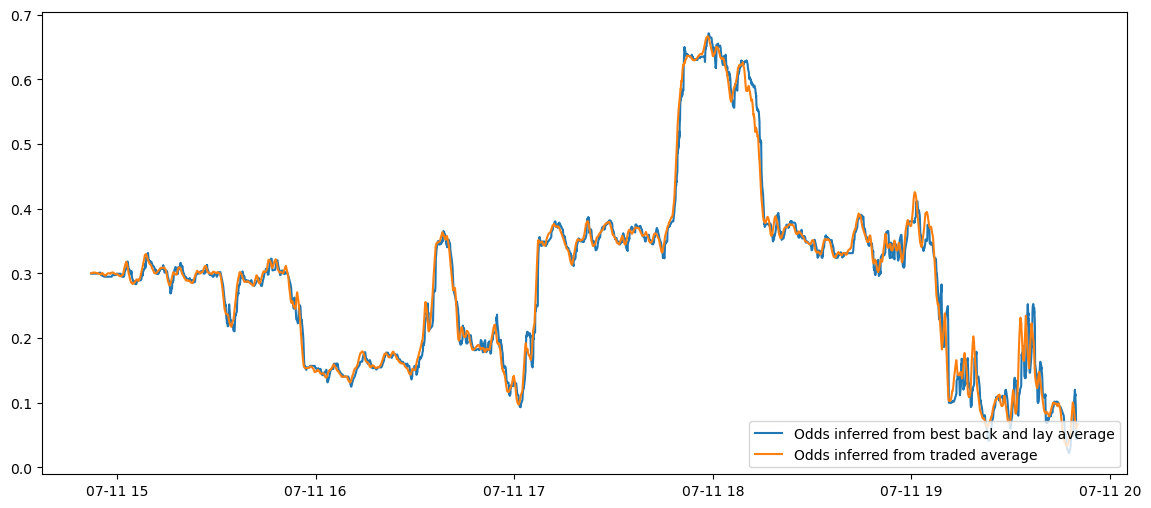

In [76]:
df_avg = df['avg']
df_blodds = ( 1 / df_runner_1['back-lay avg'] + 1 - 1 / df_runner_2['back-lay avg'] ) / 2
df_odds = pd.concat([df_avg, df_blodds], axis=1)
df_odds.columns = ['ltp odds', 'back lay odds']
print(df_odds)
plt.figure(figsize=(14,6))
plt.plot(df_odds)
plt.legend(['Odds inferred from best back and lay average', 'Odds inferred from traded average'], loc='lower right')

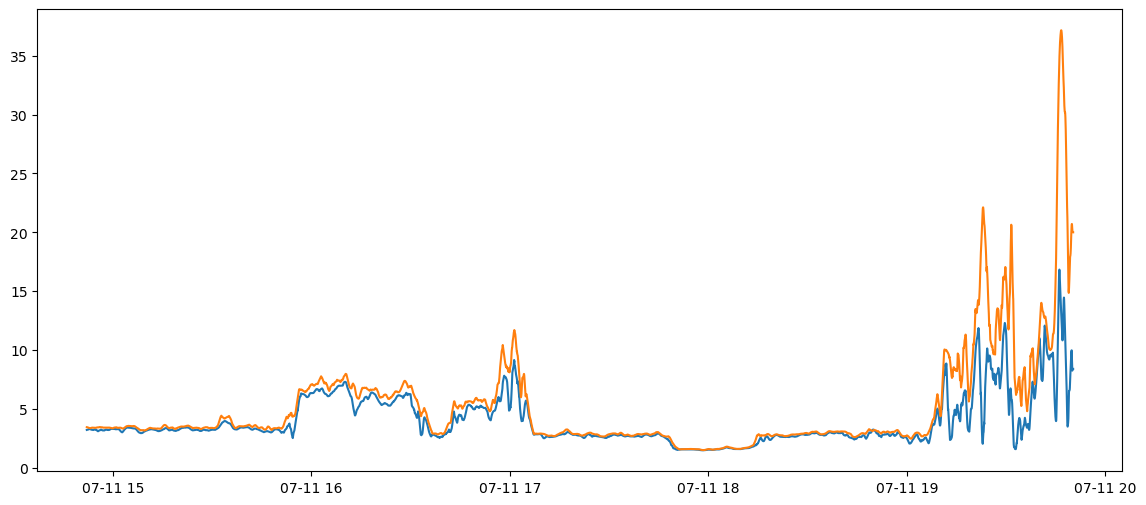

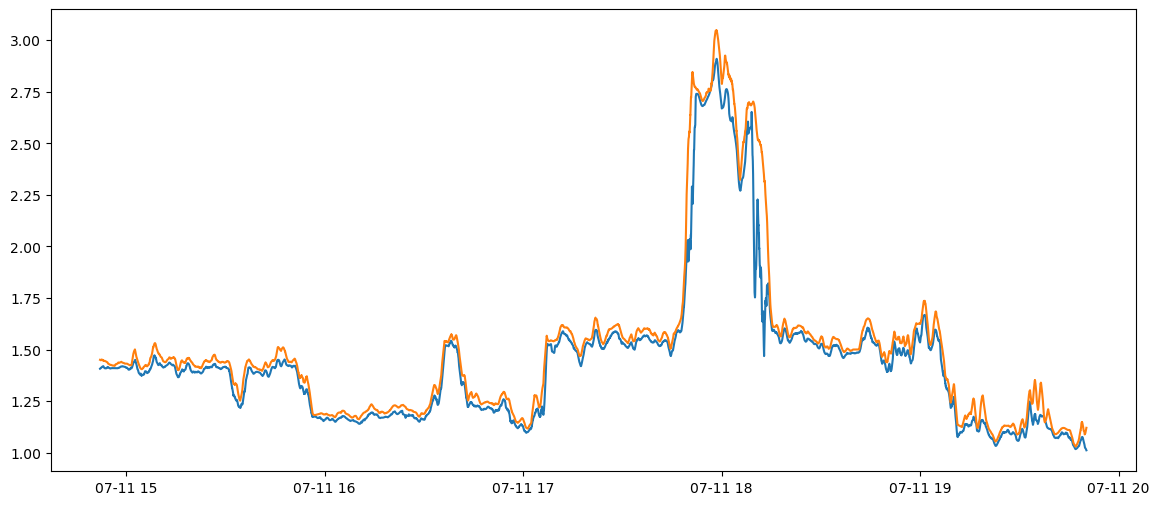

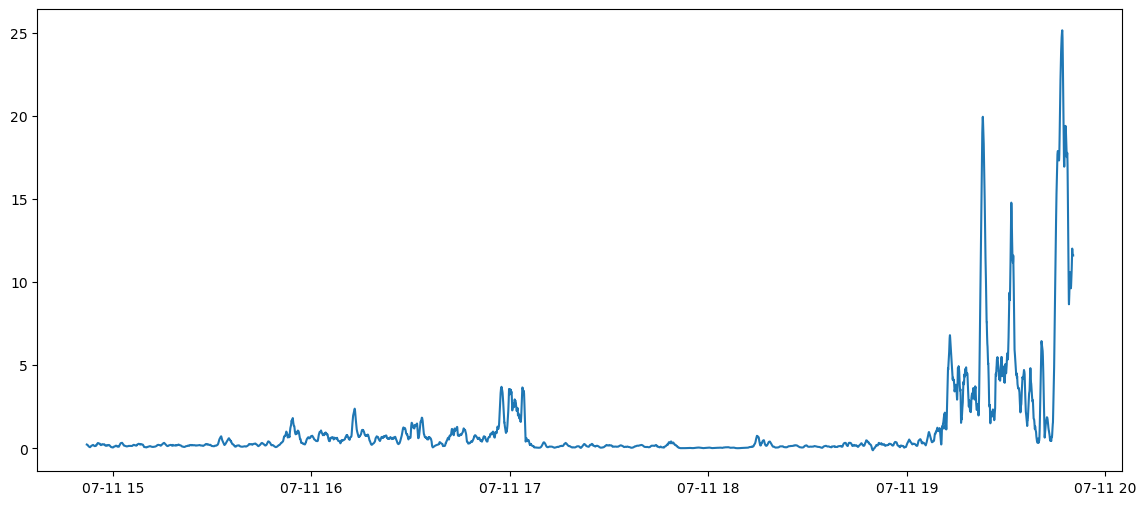

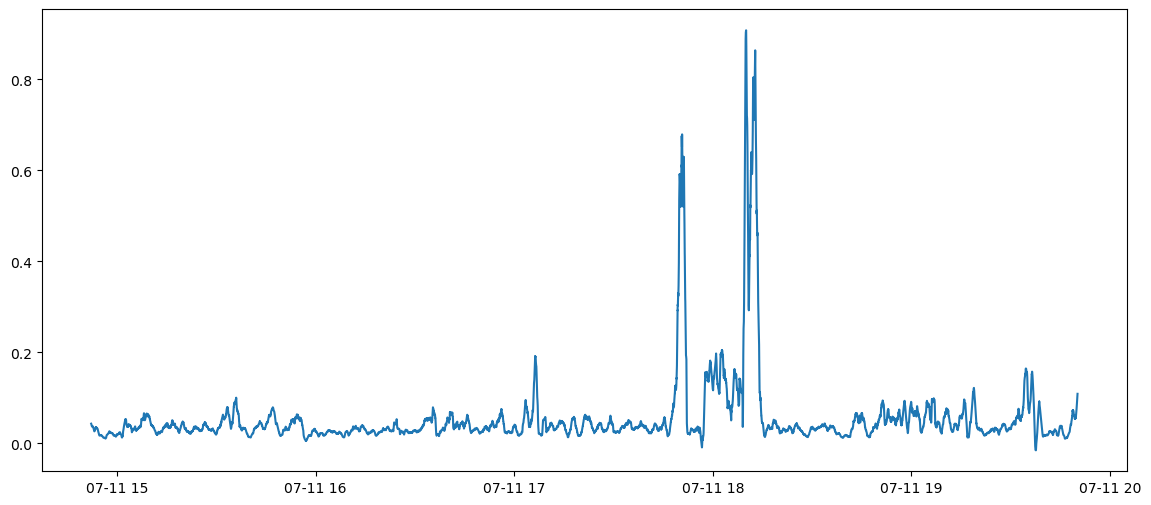

In [77]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['spread']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['spread']])

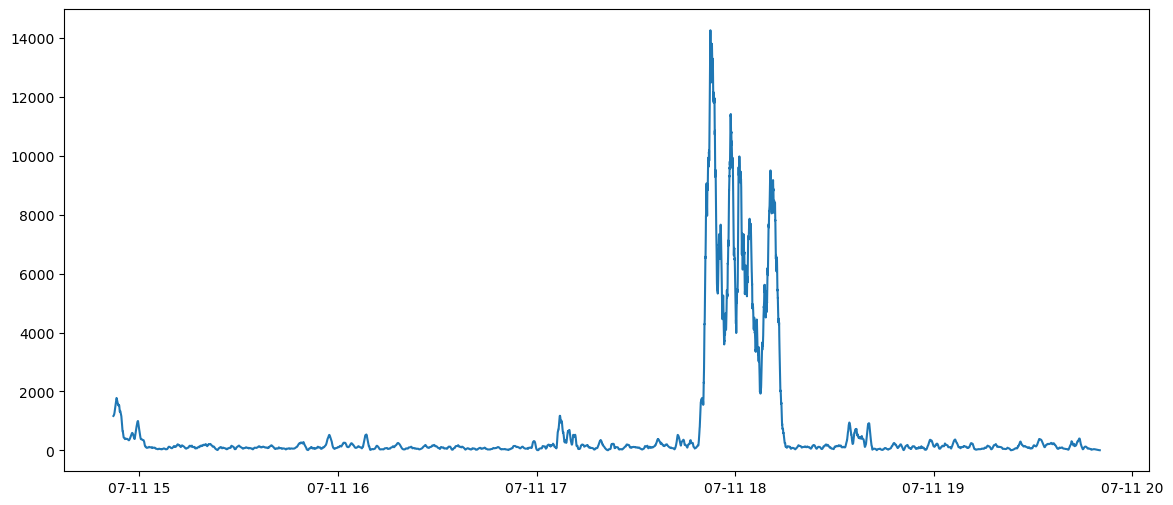

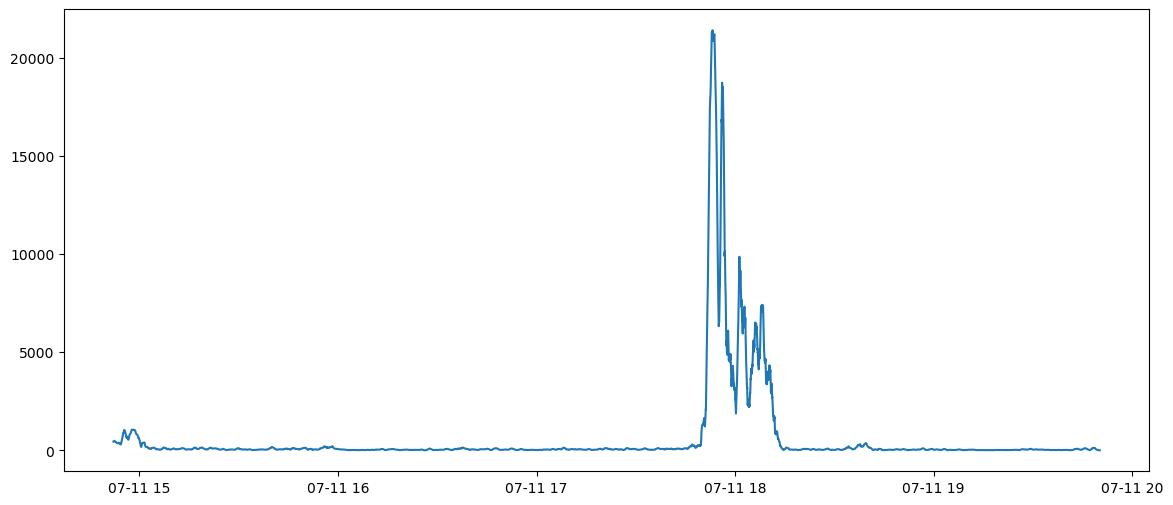

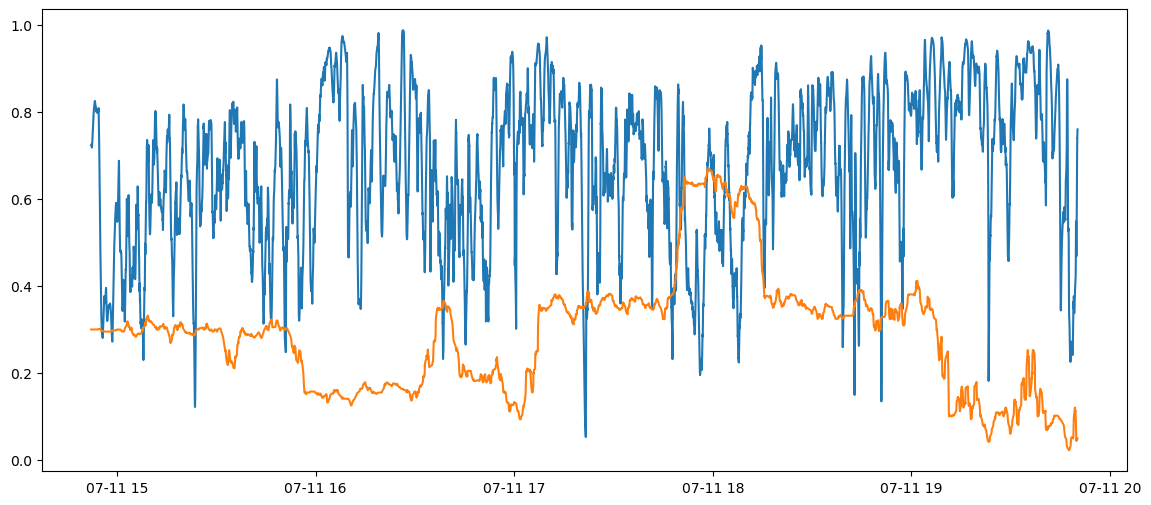

In [79]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['lay vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['pup']])
plt.plot(df_odds['ltp odds'])

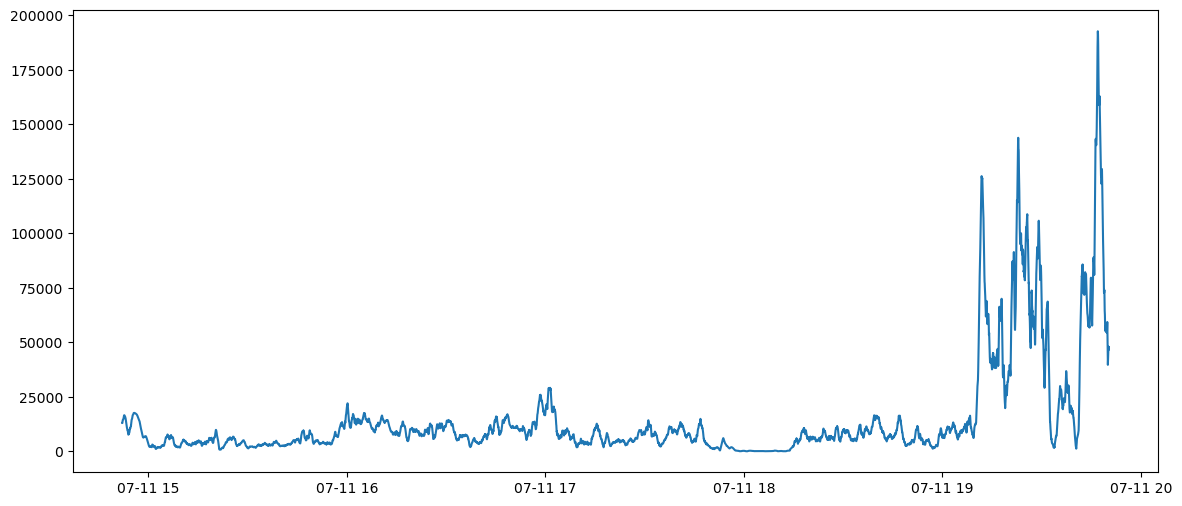

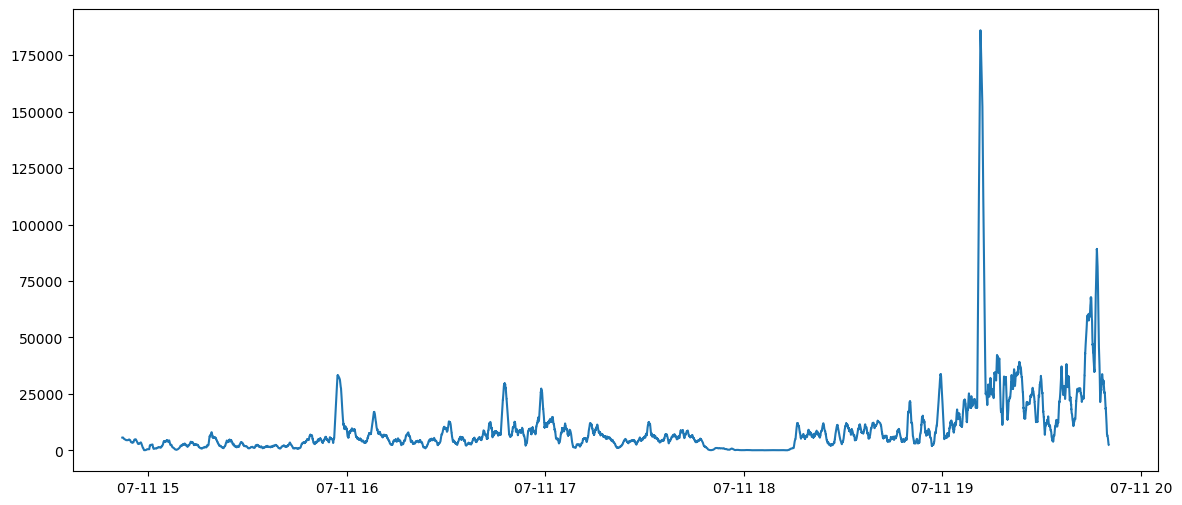

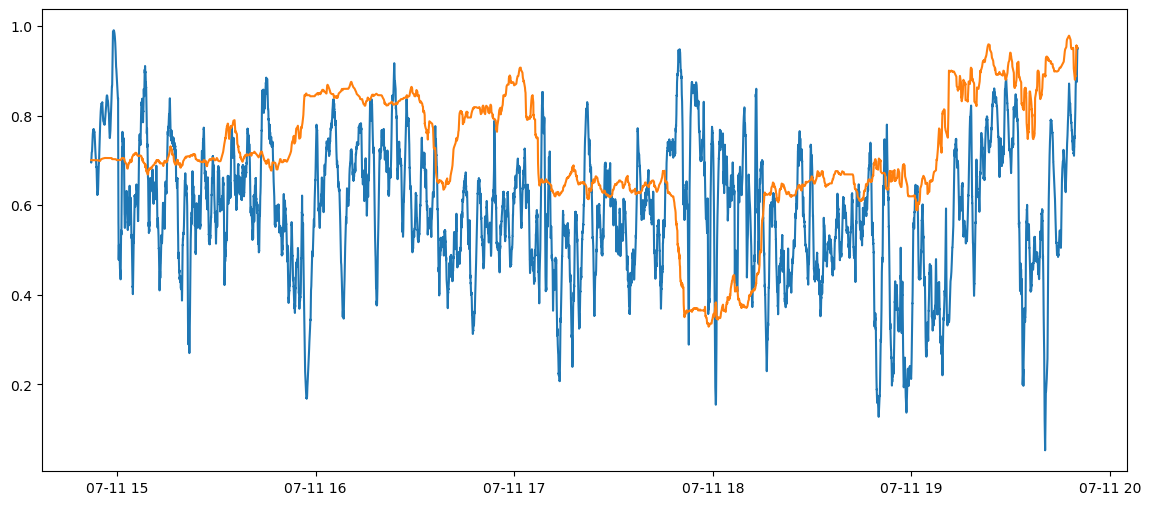

In [81]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['lay vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['pup']])
plt.plot(1 - df_odds['ltp odds'])